<a href="https://colab.research.google.com/github/Nayeon-20231348/NLP_2024/blob/main/14_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🐣 🐥 **Tokenization**

In [1]:
#!pip install nltk is a command to install the NLTK library. The installation is a one-time process.
!pip install nltk

#'import nltk' is a statement to make the NLTK library available for use in your Python code. The import statement is used in each script or notebook where you want to utilize NLTK functionality.
import nltk

In [5]:
! git clone https://github.com/Nayeon-20231348/NLP_2024

Cloning into 'NLP_2024'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 271 (delta 113), reused 31 (delta 31), pack-reused 94 (from 1)
Receiving objects: 100% (271/271), 2.76 MiB | 9.16 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [6]:
import pandas as pd

# Define the file path to your CSV file
#👉 Modify
file_path = "/content/NLP_2024/Sample_ClassActivity/Aesop4Children_CSV_BodyONY_Sample4ClassActivity.csv" #👉 Modify

# Load the CSV file into a pandas DataFrame
try:
    df = pd.read_csv(file_path)

    # Print the list of columns in the CSV file
    print("List of columns:", df.columns.tolist())

except FileNotFoundError:
    print(f"Error: The file at '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
except pd.errors.ParserError:
    print("Error: The file could not be parsed.")

List of columns: ['Text']


#**🐣🐣 <font color = 'green'>Word2Vec (Frequently used word pairs)**

#**<font color = 'green'> Use the following script for semantically related word pairs by the Word2Vec class.**

In [7]:
import pandas as pd
import nltk
from gensim.models import Word2Vec
import string
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab') #👉 ADDed
nltk.download('stopwords')

from nltk.corpus import stopwords

# Step 1: Load and Verify the CSV File
def load_and_verify_csv(file_path, text_column):
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Print original column names to verify
        print("Original Column Names:", df.columns.tolist())

        # Standardize column names: strip spaces and convert to lowercase
        df.columns = df.columns.str.strip().str.lower()
        print("Standardized Column Names:", df.columns.tolist())

        # Check if the text column exists
        if text_column.lower() not in df.columns:
            raise KeyError(f"Column '{text_column}' not found in the CSV file.")

        # Extract text data
        text_list = df[text_column.lower()].dropna().tolist()
        print(f"Successfully loaded {len(text_list)} text entries from '{text_column}' column.")
        return text_list
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
    except KeyError as e:
        print(e)

# Step 2: Preprocess Text with Stopword Removal and Content Word Filtering
def preprocess_text(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))  # Adjust language as needed
    for text in text_list:
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenize words
        tokens = nltk.word_tokenize(text.lower())
        # Remove stopwords and non-alphabetic tokens
        filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
        all_tokens.append(filtered_tokens)
    return all_tokens

# Step 3: Train Word2Vec Model
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec model training completed.")
    return model

# Step 4: Find Semantically Related Word Pairs Excluding Function Words
def find_semantically_related_pairs(model, top_n=100):
    words = list(model.wv.index_to_key)
    word_pairs = []
    stop_words = set(stopwords.words('english'))  # Reuse the stopwords set for filtering

    # Using Gensim's most_similar method to find similar words
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)  # Adjust topn as needed
        for similar_word, similarity in similar_words:
            # Ensure both words are not in stopwords and are alphabetic
            if similar_word in stop_words:
                continue  # Skip if similar_word is a stopword
            # To avoid duplicate pairs (word1-word2 and word2-word1), sort them
            sorted_pair = tuple(sorted([word, similar_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))

    # Sort the pairs based on similarity
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)

    # Return the top N pairs
    return word_pairs[:top_n]

# Step 5: Generate Network Graph
def generate_network_graph(word_pairs, similarity_threshold=0.8, save_path=None):
    """
    Generates a network graph from semantically related word pairs.

    :param word_pairs: List of tuples (Word1, Word2, Similarity)
    :param similarity_threshold: Minimum similarity score to include an edge
    :param save_path: If provided, saves the graph to the specified path
    """
    G = nx.Graph()

    # Add edges with similarity above the threshold
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)

    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold. Adjust the threshold and try again.")
        return

    # Set positions using spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Extract edge weights for visualization
    edges = G.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]

    # Normalize weights for edge thickness
    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]  # Scale edge widths

    # Draw nodes
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')

    # Draw edges with widths based on similarity
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title("Semantically Related Word Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Network graph saved to '{save_path}'.")

    plt.show()

# Step 6: Main Function to Execute the Workflow
def main():
    # Define file path and text column
    #👉 Modify
    file_path = "/content/NLP_2024/Sample_ClassActivity/4_Aesop4Children_CSV_BodyONY_Sample4ClassActivity.csv" #👉 Modify
    #👉 Modify
    text_column = "Text"  # Corrected to match the actual column name  #👉 Modify

    # Load and verify the CSV
    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    # Preprocess the text with stopword removal and content word filtering
    sentences = preprocess_text(text_list)

    # Train the Word2Vec model
    model = train_word2vec_model(sentences)

    # Find semantically related word pairs excluding function words
    top_n = 100  # Number of top related word pairs to display
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    # Create a DataFrame from the related word pairs
    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])

    # Save the results to a CSV file
    output_file = "/content/semantically_related_word_pairs.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    # Generate Network Graph
    print("\nGenerating network graph...")
    generate_network_graph(related_word_pairs, similarity_threshold=0.8, save_path="/content/semantically_related_word_pairs_graph.png")

# Execute the main function
if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Original Column Names: ['Text']
Standardized Column Names: ['text']
Successfully loaded 4 text entries from 'Text' column.
Word2Vec model training completed.

Top 100 Semantically Related Word Pairs saved to '/content/semantically_related_word_pairs.csv'.

Generating network graph...
No edges meet the similarity threshold. Adjust the threshold and try again.


#**🐣🐣 <font color = 'green'>Word2Vec & plotting (Frequently used word pairs)**

In [8]:
!pip install pandas nltk gensim scikit-learn networkx matplotlib

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Original Column Names: ['Text']
Standardized Column Names: ['text']
Successfully loaded 4 text entries from 'Text' column.

Sample Preprocessed Sentences:
1: ['little', 'kid', 'growing', 'horns', 'made', 'think', 'grownup', 'billy', 'goat', 'able', 'take', 'care', 'evening', 'flock', 'started', 'home', 'pasture', 'mother', 'called', 'kid', 'paid', 'heed', 'kept', 'right', 'nibbling', 'tender', 'grass', 'little', 'later', 'lifted', 'head', 'flock', 'gone', 'alone', 'sun', 'sinking', 'long', 'shadows', 'came', 'creeping', 'ground', 'chilly', 'little', 'wind', 'came', 'creeping', 'making', 'scary', 'noises', 'grass', 'kid', 'shivered', 'thought', 'terrible', 'wolf', 'started', 'wildly', 'field', 'bleating', 'mother', 'halfway', 'clump', 'trees', 'wolf', 'kid', 'knew', 'little', 'hope', 'please', 'mr', 'wolf', 'said', 'trembling', 'know', 'going', 'eat', 'first', 'please', 'pipe', 'tune', 'want', 'dance', 'merry', 'long', 'wolf', 'liked', 'idea', 'little', 'music', 'eating', 'struck', 'mer

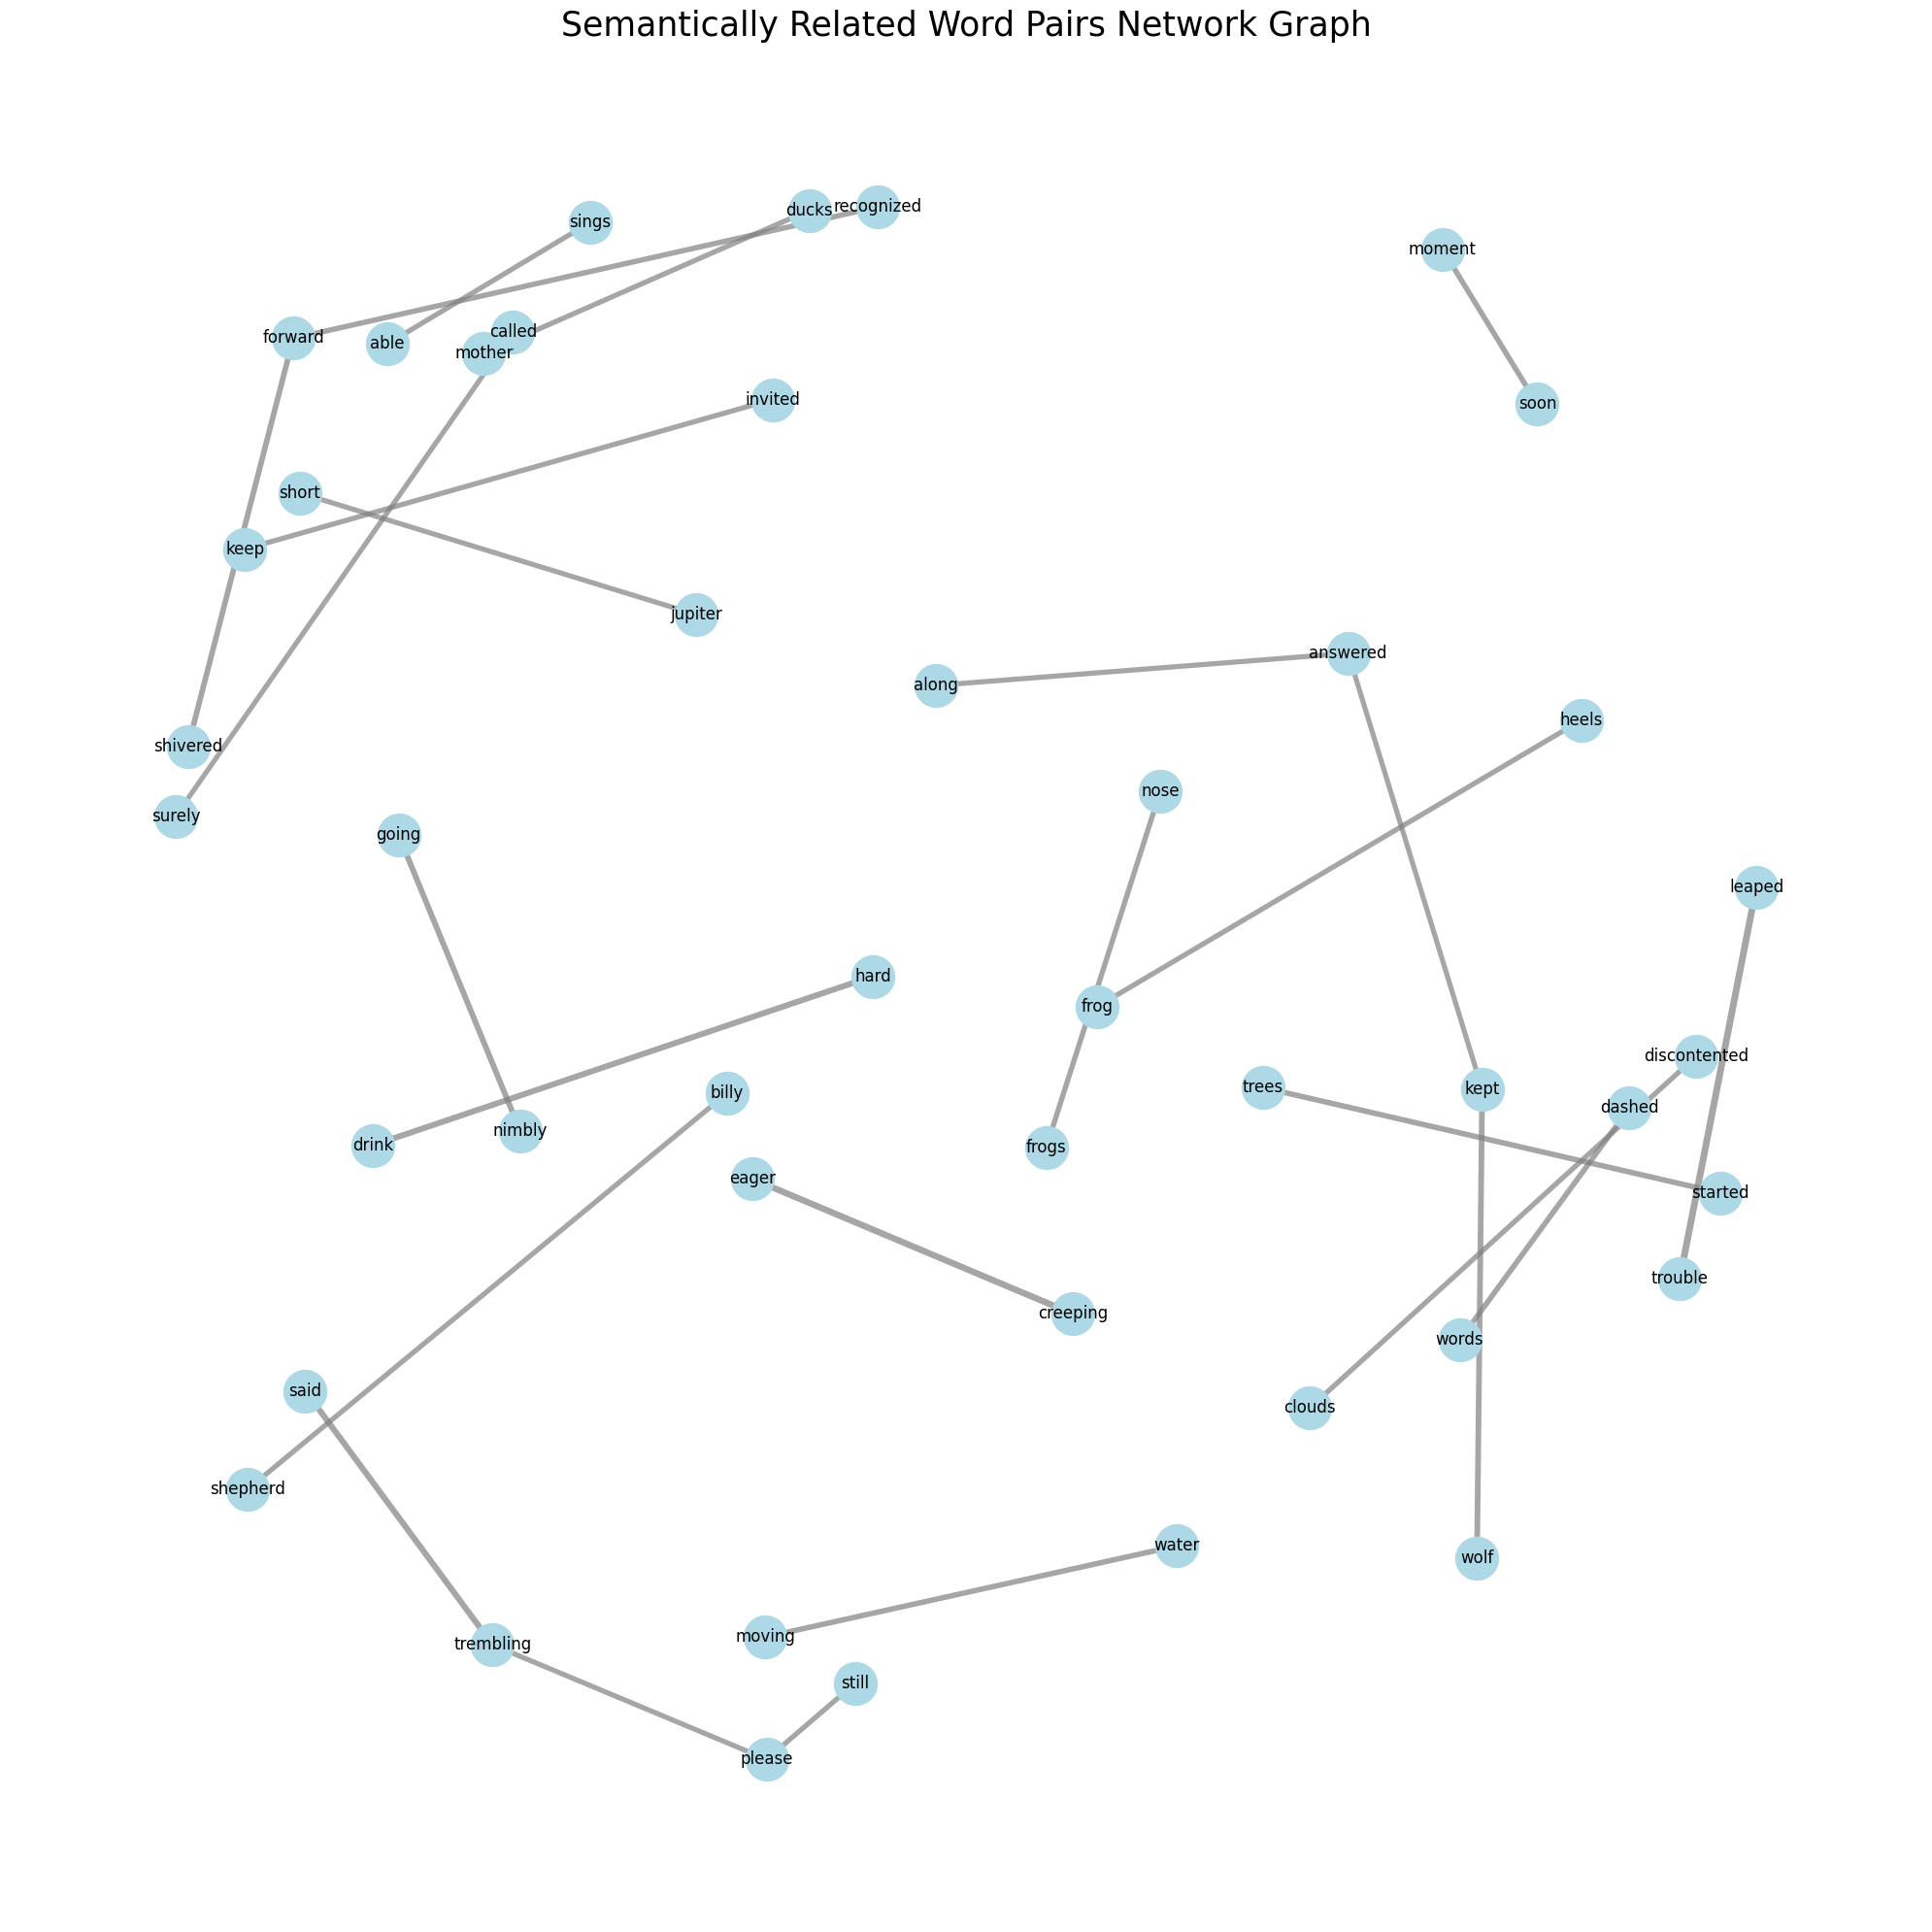

In [9]:
import pandas as pd
import nltk
from gensim.models import Word2Vec
import string
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab') #👉 Added
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng') #👉 ADDed
nltk.download('wordnet')

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Step 1: Load and Verify the CSV File
def load_and_verify_csv(file_path, text_column):
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Print original column names to verify
        print("Original Column Names:", df.columns.tolist())

        # Standardize column names: strip spaces and convert to lowercase
        df.columns = df.columns.str.strip().str.lower()
        print("Standardized Column Names:", df.columns.tolist())

        # Check if the text column exists
        if text_column.lower() not in df.columns:
            raise KeyError(f"Column '{text_column}' not found in the CSV file.")

        # Extract text data
        text_list = df[text_column.lower()].dropna().tolist()
        print(f"Successfully loaded {len(text_list)} text entries from '{text_column}' column.")
        return text_list
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
    except KeyError as e:
        print(e)


# Step 2: Preprocess Text with Stopword Removal and POS Filtering
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenize words
        tokens = nltk.word_tokenize(text.lower())
        # POS tagging
        pos_tags = pos_tag(tokens)
        # Filter tokens: remove stopwords, non-alphabetic, and keep only content POS
        filtered_tokens = [
            word for word, pos in pos_tags
            if word not in stop_words and word.isalpha() and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# Step 3: Train Word2Vec Model
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4): #100 dimensionality, 11 words tested each (5 words to the left, target word, 5 words to the right)
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec model training completed.")
    return model

# Step 4: Find Semantically Related Word Pairs Excluding Function Words
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    stop_words = set(stopwords.words('english'))  # Reuse the stopwords set for filtering

    # Using Gensim's most_similar method to find similar words
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)  # Adjust topn as needed
        for similar_word, similarity in similar_words:
            # Ensure similar_word is not a stopword and is alphabetic
            if similar_word in stop_words:
                continue  # Skip if similar_word is a stopword
            # To avoid duplicate pairs (word1-word2 and word2-word1), sort them
            sorted_pair = tuple(sorted([word, similar_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))

    # Sort the pairs based on similarity
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)

    # Return the top N pairs
    return word_pairs[:top_n]

# Step 5: Generate Network Graph
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    """
    Generates a network graph from semantically related word pairs.

    :param word_pairs: List of tuples (Word1, Word2, Similarity)
    :param similarity_threshold: Minimum similarity score to include an edge
    :param save_path: If provided, saves the graph to the specified path
    """
    G = nx.Graph()

    # Add edges with similarity above the threshold
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)

    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold. Adjust the threshold and try again.")
        return

    # Set positions using spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Extract edge weights for visualization
    edges = G.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]

    # Normalize weights for edge thickness
    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]  # Scale edge widths

    # Draw nodes
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')

    # Draw edges with widths based on similarity
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title("Semantically Related Word Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Network graph saved to '{save_path}'.")

    plt.show()

# Step 6: Main Function to Execute the Workflow
def main():
    # Define file path and text column
    #👉 Modify
    file_path = "/content/NLP_2024/Sample_ClassActivity/4_Aesop4Children_CSV_BodyONY_Sample4ClassActivity.csv"  #👉 Modify
    #👉 Modify
    text_column = "Text"  # Correctly set to match the actual column name  #👉 Modify

    # Load and verify the CSV
    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    # Preprocess the text with stopword removal and content word filtering
    sentences = preprocess_text_with_pos(text_list)

    # Debug: Print sample preprocessed sentences
    print("\nSample Preprocessed Sentences:")
    for i, sentence in enumerate(sentences[:3], 1):
        print(f"{i}: {sentence}")

    # Train the Word2Vec model
    model = train_word2vec_model(sentences)

    # Find semantically related word pairs excluding function words
    top_n = 50  # Reduced to 50 for a smaller dataset
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    # Debug: Print the found word pairs and their similarity scores
    print("\nSemantically Related Word Pairs:")
    for pair in related_word_pairs:
        print(f"{pair[0]} - {pair[1]}: Similarity = {pair[2]:.4f}")

    # Create a DataFrame from the related word pairs
    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])

    # Save the results to a CSV file
    output_file = "/content/semantically_related_word_pairs.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    # Generate Network Graph with a lower similarity threshold
    print("\nGenerating network graph...")
    # If higher numbers do not generate graph, try to lower this value. For the text used here, lower than 0.4 will generate a graph. Here we use 0.3.
    similarity_threshold = 0.3  #👉 Modify: Lowered threshold to include more edges
    generate_network_graph(related_word_pairs, similarity_threshold=similarity_threshold, save_path="/content/semantically_related_word_pairs_graph.png")

# Execute the main function
if __name__ == "__main__":
    main()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Original Column Names: ['Text']
Standardized Column Names: ['text']
Successfully loaded 4 text entries from 'Text' column.
Word2Vec model training completed.

Top 100 Semantically Related Word Pairs saved to '/content/semantically_related_word_pairs.csv'.

Generating network graph...


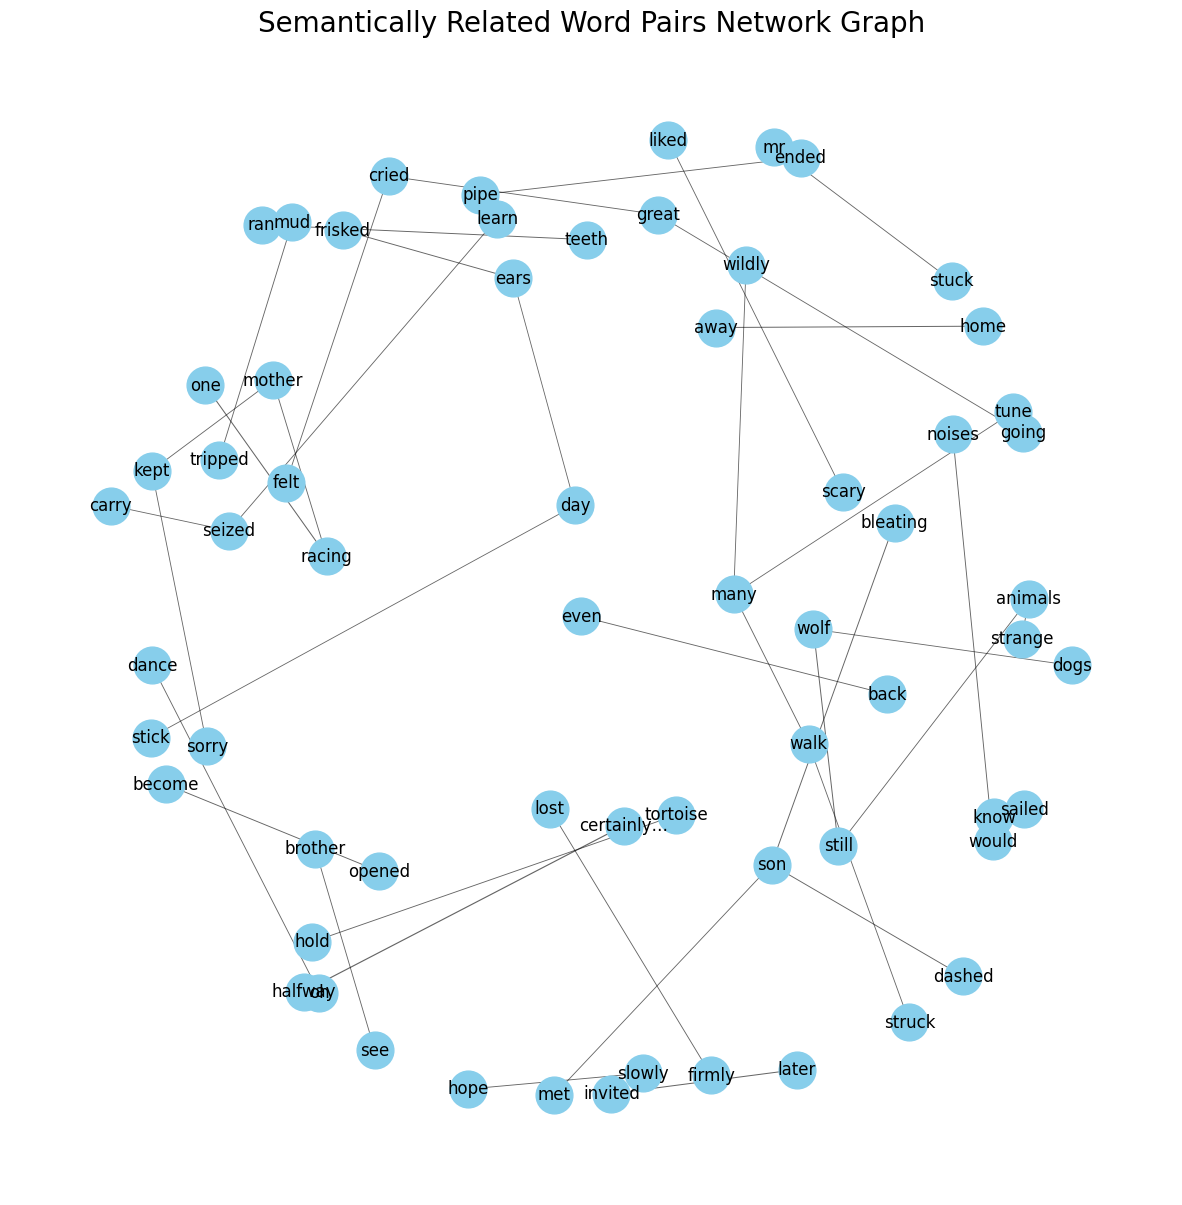

In [10]:
import pandas as pd
import nltk
from gensim.models import Word2Vec
import string
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

# Step 1: Load and Verify the CSV File
def load_and_verify_csv(file_path, text_column):
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Print original column names to verify
        print("Original Column Names:", df.columns.tolist())

        # Standardize column names: strip spaces and convert to lowercase
        df.columns = df.columns.str.strip().str.lower()
        print("Standardized Column Names:", df.columns.tolist())

        # Check if the text column exists
        if text_column.lower() not in df.columns:
            raise KeyError(f"Column '{text_column}' not found in the CSV file.")

        # Extract text data
        text_list = df[text_column.lower()].dropna().tolist()
        print(f"Successfully loaded {len(text_list)} text entries from '{text_column}' column.")
        return text_list
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
    except KeyError as e:
        print(e)

# Step 2: Preprocess Text with Stopword Removal
def preprocess_text(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))  # Adjust language as needed
    for text in text_list:
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenize words
        tokens = nltk.word_tokenize(text.lower())
        # Remove stopwords
        filtered_tokens = [word for word in tokens if word not in stop_words]
        all_tokens.append(filtered_tokens)
    return all_tokens

# Step 3: Train Word2Vec Model
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec model training completed.")
    return model

# Step 4: Find Semantically Related Word Pairs
def find_semantically_related_pairs(model, top_n=100):
    words = list(model.wv.index_to_key)
    word_pairs = []

    # Using Gensim's most_similar method to find similar words
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)  # Adjust topn as needed
        for similar_word, similarity in similar_words:
            # To avoid duplicate pairs (word1-word2 and word2-word1), sort them
            sorted_pair = tuple(sorted([word, similar_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))

    # Sort the pairs based on similarity
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)

    # Return the top N pairs
    return word_pairs[:top_n]

# Step 5: Generate Network Graph
def generate_network_graph(word_pairs, similarity_threshold=0.8):
    """
    Generates a network graph from semantically related word pairs.

    :param word_pairs: List of tuples (Word1, Word2, Similarity)
    :param similarity_threshold: Minimum similarity score to include an edge
    """
    G = nx.Graph()

    # Add edges with similarity above the threshold
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)

    # Set positions using spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Extract edge weights for visualization
    edges = G.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]

    # Draw nodes
    plt.figure(figsize=(15, 15))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')

    # Draw edges with widths based on similarity
    nx.draw_networkx_edges(G, pos, width=[weight * 2 for weight in weights], alpha=0.6)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title("Semantically Related Word Pairs Network Graph", fontsize=20)
    plt.axis('off')
    plt.show()

# Step 6: Main Function to Execute the Workflow
def main():
    # Define file path and text column
    #👉 Modify
    file_path = "/content/NLP_2024/Sample_ClassActivity/4_Aesop4Children_CSV_BodyONY_Sample4ClassActivity.csv"
    #👉 Modify
    text_column = "Text"  # Ensure this matches the actual column name #👉 Modify

    # Load and verify the CSV
    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    # Preprocess the text with stopword removal
    sentences = preprocess_text(text_list)

    # Train the Word2Vec model
    model = train_word2vec_model(sentences)

    # Find semantically related word pairs
    top_n = 100  # Number of top related word pairs to display
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    # Create a DataFrame from the related word pairs
    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])

    # Save the results to a CSV file
    output_file = "/content/semantically_related_word_pairs.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    # Generate Network Graph
    print("\nGenerating network graph...")
    #👉 Modify the value of threshold as you refer to values above...
    generate_network_graph(related_word_pairs, similarity_threshold=0.3)  # Adjust threshold as needed

# Execute the main function
if __name__ == "__main__":
    main()
